# Autofocus 
This is a notebook to provide a boilerplate for an autofocus routine triggered by the imswitch client.


In [2]:
import imswitchclient.ImSwitchClient as imc
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

# Connect to ImSwitch
hostname = "localhost"  # Change to the hostname of the computer running ImSwitch
port = 8001
isHttps = False
client = imc.ImSwitchClient(port=port, isHttps=isHttps)


In [4]:

# Example: move XY to a certain position before focusing
client.positionersManager.movePositioner(None, "X", 10, is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(None, "Y", 10, is_absolute=True, is_blocking=True)

# retreive the current Z position
positioner_name = client.positionersManager.allStageNames[0]
currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
initialPosition = (currentPositions["X"], currentPositions["Y"])
initialPosiionZ = currentPositions["Z"]

# Define focus metric (Laplacian variance)
def focus_metric(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

# Define Z positions to sweep through
z_start = - 20
z_end   = 20
z_step  = 10
z_positions = np.arange(z_start, z_end + z_step, z_step) + initialPosiionZ
t_wait  = 0.5  # Time to wait after moving Z

# Move down to the lowest position
client.positionersManager.movePositioner(None, "Z", z_positions[0], is_absolute=True, is_blocking=True)

captured_images = []
focus_scores = []

# Sweep through Z positions, capture images, measure focus
for index, z in enumerate(z_positions):
    client.positionersManager.movePositioner(None, "Z", z, is_absolute=True, is_blocking=True)
    time.sleep(t_wait)  # Adjust as needed to allow stage/camera to settle

    # Replace this call with the appropriate function if different
    # The returned image should be a 2D numpy array if single channel
    img = client.recordingManager.snapNumpyToFastAPI()

    score = focus_metric(img)
    captured_images.append(img)
    focus_scores.append(score)
    print(f"i: {index}, Z = {z}, Focus score = {score}")

# Determine best focus position
best_focus_index = np.argmax(focus_scores)
best_focus_z = z_positions[best_focus_index] + initialPosiionZ

# Move objective to best focus position
client.positionersManager.movePositioner(None, "Z", best_focus_z, is_absolute=True, is_blocking=True)



i: 0, Z = -20.0, Focus score = 0.0
i: 1, Z = -10.0, Focus score = 0.0
i: 2, Z = 0.0, Focus score = 35274.56050736417
i: 3, Z = 10.0, Focus score = 0.0
i: 4, Z = 20.0, Focus score = 0.0


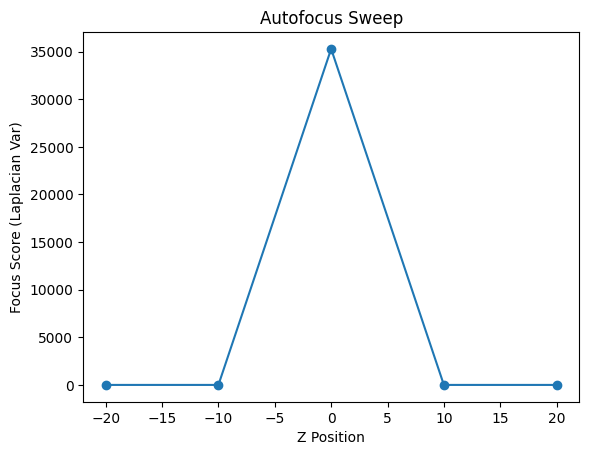

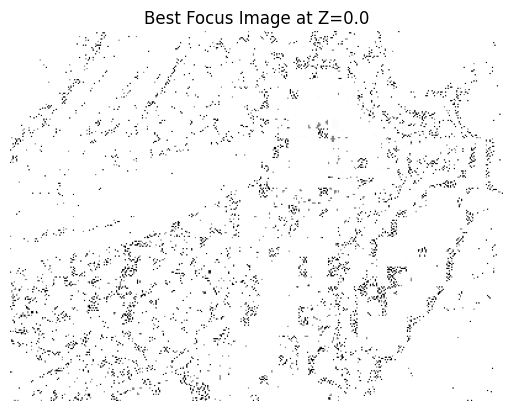

In [5]:
# Plot the focus metric curve
plt.figure()
plt.plot(z_positions, focus_scores, marker='o')
plt.xlabel('Z Position')
plt.ylabel('Focus Score (Laplacian Var)')
plt.title('Autofocus Sweep')
plt.show()

# Show the best-focused image
plt.figure()
plt.imshow(captured_images[best_focus_index], cmap='gray')
plt.title(f'Best Focus Image at Z={best_focus_z}')
plt.axis('off')
plt.show()
